<a href="https://colab.research.google.com/github/graviada/colabRepo/blob/master/2022/TorchML%20(6%2C%202022)/Lab4/PyTorch_Lab4_2_VaeMnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn

import torch.optim as optim
from itertools import chain

from torchvision.transforms import ToTensor
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader

from torchsummary import summary
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation

import numpy as np
from sklearn.manifold import TSNE
from tqdm import tqdm

In [2]:
# В этой части лабораторной работы вам предстоит спроектировать, реализовать и обучить вариационный автокодировщик для генерации рукописных цифр.
# Сценарий выполнения кода:
# 1. Обучение автокодировщика.
# 2. Отображение проекции скрытого пространства на плоскость для визуальной оценки распределения данных в скрытом пространстве.
# 3. Интерполяция между несколькими точками в скрытом пространстве, декодирование промежуточных точек в исходное пространство
# и анимация результата.
# 4. Генерация нескольких изображений цифр.
class Encoder(nn.Module):
    # Класс кодировщика, нужно реализовать.

    def __init__(self, latent_size):
        super().__init__()
        # ВАШ КОД ЗДЕСЬ
        self.convs = nn.Sequential(
            nn.Conv2d(1, 8, 3, 1, 1),
            nn.ReLU(),
            nn.Conv2d(8, 32, 3, 1, 1),
            nn.ReLU(),
        )
        self.mu = nn.Linear(32*28*28, latent_size)
        self.log_var = nn.Linear(32*28*28, latent_size)

        self.latent_size = latent_size
        # ============

    def forward(self, x):
        mu = 0 # модельное математическое ожидание z, нужно вычислить.
        log_var = 0  # модельный логарифм дисперсии z, нужно вычислить.
        
        x = self.convs(x)
        x = x.view(x.size(0), -1)
        
        mu = self.mu(x) # модельное математическое ожидание z, нужно вычислить.
        log_var = torch.exp(self.log_var(x)) # модельный логарифм дисперсии z, нужно вычислить.
        return mu, log_var

    def sample_latent(self, x):
        # Метод для выборки z при помощи кодировщика.
        mu, log_var = self(x)
        return torch.randn_like(mu).to(device) * torch.exp(0.5 * log_var) + mu, mu, log_var

In [3]:
class Decoder(nn.Module):
    # Класс декодировщика, нужно реализовать.

    def __init__(self, latent_size):
        super().__init__()
        self.upconvs = nn.Sequential(
            nn.ConvTranspose2d(32, 8, 3, 1, 1),
            nn.ReLU(),
            nn.ConvTranspose2d(8, 1, 3, 1, 1)
        )
        self.linear = nn.Linear(latent_size, 32*28*28)

        self.relu = nn.ReLU()

    def forward(self, x):
        # ВАШ КОД ЗДЕСЬ
        x = self.linear(x)
        x = self.relu(x)
        x = x.view(x.size(0), -1, 28, 28)
        x = self.upconvs(x)
        # ============
        return x

In [4]:
def KL(mu, log_var):
  return (-0.5 * (1 + log_var - mu**2- torch.exp(log_var)).sum(dim = 1)).mean(dim =0)

In [5]:
def train_ae(data_loader, encoder, decoder, epochs, lr, device):
    # Функция для обучения автокодировщика.
    # Принимает на вход загрузчик тренеровочных данных,
    # кодировщик, декодировщик, количество эпох для обучения, скорость обучения и устройство,
    # на котором находится автокодировщик (cpu или cuda).

    print('Обучение автокодировщика..')

    encoder.train()
    decoder.train()
    
    alpha = 0.001
    recon_loss_func = nn.MSELoss()  # Функция потерь восстановления, нужно выбрать.
    kl_loss_func = KL # Функция потерь похожести распределения на нормальное.
    optimizer = optim.AdamW(chain(encoder.parameters(), decoder.parameters()), lr=lr)  # Оптимизатор, нужно выбрать и настроить.
    loss_history = list()

    for epoch in range(epochs):
        for i, (batch, _) in enumerate(tqdm(data_loader)):
            # ВАШ КОД ЗДЕСЬ
            optimizer.zero_grad()
            batch = batch.to(device)
            mu, log_var = encoder(batch)
            # скрытый вектор z в скрытом пространстве
            z = encoder.sample_latent(batch)[0]
            kl_loss = KL(mu, log_var)
            output = decoder(z)
            size = batch.shape[0]
            output = torch.reshape(output, (size, 1, 28, 28))

            recon_loss = recon_loss_func(batch, output)
            loss = recon_loss + kl_loss * alpha

            loss.backward()
            optimizer.step()
            # ============
            if i % 100 == 0:
                print('Потери восстановления:', recon_loss.item())
                print('Потери расхождения распределений:', kl_loss.item())
            loss_history.append(loss.log().item())
        print(f'Эпоха {epoch + 1} / {epochs}. Потери на последнем пакете: {loss.item()}')

    encoder.eval()
    decoder.eval()

    print('Готово!')

    plt.plot(loss_history)
    plt.show()

In [6]:
def lerp(v1, v2, t):
    # Функция для линейной интерполяции между двумя векторами.
    return v1 * (1 - t) + v2 * t

def get_frame(i, data):
    # Функция для анимации
    i = min(i, len(data) - 1)
    ax.clear()
    ax.imshow(data[i])

In [7]:
LATENT_SIZE = 32  # размерность скрытого пространства, можно варьировать.

BATCH_SIZE = 256
EPOCHS = 10
LEARNING_RATE = 1e-4

ANIMATION_IMAGES = 5
ANIMATION_N_FRAMES = (ANIMATION_IMAGES - 1) * 20
ANIMATION_INTERVAL = 50

device = 'cuda' if torch.cuda.is_available() else 'cpu'

encoder = Encoder(LATENT_SIZE).to(device)
decoder = Decoder(LATENT_SIZE).to(device)

summary(encoder, [[1, 28, 28]])
summary(decoder, [[LATENT_SIZE]])

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 28, 28]              80
              ReLU-2            [-1, 8, 28, 28]               0
            Conv2d-3           [-1, 32, 28, 28]           2,336
              ReLU-4           [-1, 32, 28, 28]               0
            Linear-5                   [-1, 32]         802,848
            Linear-6                   [-1, 32]         802,848
Total params: 1,608,112
Trainable params: 1,608,112
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.48
Params size (MB): 6.13
Estimated Total Size (MB): 6.62
----------------------------------------------------------------
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                [

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw

Обучение автокодировщика..


  0%|          | 1/235 [00:01<05:07,  1.32s/it]

Потери восстановления: 0.4446229338645935
Потери расхождения распределений: 11.305392265319824


 43%|████▎     | 101/235 [01:12<01:24,  1.59it/s]

Потери восстановления: 0.10455798357725143
Потери расхождения распределений: 3.404819965362549


 86%|████████▌ | 201/235 [02:16<00:21,  1.57it/s]

Потери восстановления: 0.07677045464515686
Потери расхождения распределений: 4.671689987182617


100%|██████████| 235/235 [02:37<00:00,  1.49it/s]


Эпоха 1 / 10. Потери на последнем пакете: 0.0805831328034401


  0%|          | 1/235 [00:00<02:30,  1.56it/s]

Потери восстановления: 0.07336103916168213
Потери расхождения распределений: 5.84250545501709


 43%|████▎     | 101/235 [01:03<01:23,  1.61it/s]

Потери восстановления: 0.06297056376934052
Потери расхождения распределений: 8.339691162109375


 86%|████████▌ | 201/235 [02:06<00:21,  1.59it/s]

Потери восстановления: 0.05805172398686409
Потери расхождения распределений: 8.655708312988281


100%|██████████| 235/235 [02:28<00:00,  1.59it/s]


Эпоха 2 / 10. Потери на последнем пакете: 0.06891999393701553


  0%|          | 1/235 [00:00<02:29,  1.56it/s]

Потери восстановления: 0.05860128253698349
Потери расхождения распределений: 9.219454765319824


 43%|████▎     | 101/235 [01:04<01:25,  1.57it/s]

Потери восстановления: 0.05332428589463234
Потери расхождения распределений: 8.544182777404785


 86%|████████▌ | 201/235 [02:07<00:21,  1.59it/s]

Потери восстановления: 0.05053437128663063
Потери расхождения распределений: 8.673701286315918


100%|██████████| 235/235 [02:28<00:00,  1.59it/s]


Эпоха 3 / 10. Потери на последнем пакете: 0.057249050587415695


  0%|          | 1/235 [00:00<02:25,  1.61it/s]

Потери восстановления: 0.04984236881136894
Потери расхождения распределений: 8.934806823730469


 43%|████▎     | 101/235 [01:02<01:23,  1.61it/s]

Потери восстановления: 0.047631677240133286
Потери расхождения распределений: 9.383550643920898


 86%|████████▌ | 201/235 [02:05<00:21,  1.61it/s]

Потери восстановления: 0.0465579554438591
Потери расхождения распределений: 9.499959945678711


100%|██████████| 235/235 [02:25<00:00,  1.61it/s]


Эпоха 4 / 10. Потери на последнем пакете: 0.05390391871333122


  0%|          | 1/235 [00:00<02:27,  1.58it/s]

Потери восстановления: 0.04651004821062088
Потери расхождения распределений: 9.662097930908203


 43%|████▎     | 101/235 [01:03<01:23,  1.60it/s]

Потери восстановления: 0.04533529281616211
Потери расхождения распределений: 9.93556022644043


 86%|████████▌ | 201/235 [02:05<00:21,  1.58it/s]

Потери восстановления: 0.042913854122161865
Потери расхождения распределений: 10.167534828186035


100%|██████████| 235/235 [02:26<00:00,  1.60it/s]


Эпоха 5 / 10. Потери на последнем пакете: 0.05426167696714401


  0%|          | 1/235 [00:00<02:35,  1.50it/s]

Потери восстановления: 0.04450192302465439
Потери расхождения распределений: 10.317339897155762


 43%|████▎     | 101/235 [01:03<01:23,  1.60it/s]

Потери восстановления: 0.043096523731946945
Потери расхождения распределений: 9.870976448059082


 86%|████████▌ | 201/235 [02:06<00:21,  1.59it/s]

Потери восстановления: 0.04079076647758484
Потери расхождения распределений: 10.545160293579102


100%|██████████| 235/235 [02:27<00:00,  1.60it/s]


Эпоха 6 / 10. Потери на последнем пакете: 0.053669605404138565


  0%|          | 1/235 [00:00<02:39,  1.47it/s]

Потери восстановления: 0.04154428839683533
Потери расхождения распределений: 9.873004913330078


 43%|████▎     | 101/235 [01:03<01:23,  1.60it/s]

Потери восстановления: 0.04183521866798401
Потери расхождения распределений: 10.455522537231445


 86%|████████▌ | 201/235 [02:06<00:21,  1.58it/s]

Потери восстановления: 0.04078621789813042
Потери расхождения распределений: 10.41617202758789


100%|██████████| 235/235 [02:27<00:00,  1.59it/s]


Эпоха 7 / 10. Потери на последнем пакете: 0.04798022285103798


  0%|          | 1/235 [00:00<02:31,  1.55it/s]

Потери восстановления: 0.03916953504085541
Потери расхождения распределений: 9.978490829467773


 43%|████▎     | 101/235 [01:03<01:24,  1.59it/s]

Потери восстановления: 0.039232004433870316
Потери расхождения распределений: 10.713248252868652


 86%|████████▌ | 201/235 [02:06<00:21,  1.57it/s]

Потери восстановления: 0.03881116211414337
Потери расхождения распределений: 10.697982788085938


100%|██████████| 235/235 [02:27<00:00,  1.59it/s]


Эпоха 8 / 10. Потери на последнем пакете: 0.048823848366737366


  0%|          | 1/235 [00:00<02:30,  1.56it/s]

Потери восстановления: 0.03970159962773323
Потери расхождения распределений: 11.052812576293945


 43%|████▎     | 101/235 [01:04<01:25,  1.58it/s]

Потери восстановления: 0.03985435888171196
Потери расхождения распределений: 11.18042278289795


 86%|████████▌ | 201/235 [02:07<00:21,  1.60it/s]

Потери восстановления: 0.038157571107149124
Потери расхождения распределений: 10.908658027648926


100%|██████████| 235/235 [02:28<00:00,  1.59it/s]


Эпоха 9 / 10. Потери на последнем пакете: 0.0491756908595562


  0%|          | 1/235 [00:00<02:28,  1.57it/s]

Потери восстановления: 0.03758600726723671
Потери расхождения распределений: 10.852910041809082


 43%|████▎     | 101/235 [01:03<01:23,  1.60it/s]

Потери восстановления: 0.039200469851493835
Потери расхождения распределений: 10.875272750854492


 86%|████████▌ | 201/235 [02:06<00:21,  1.59it/s]

Потери восстановления: 0.03895089402794838
Потери расхождения распределений: 11.432512283325195


100%|██████████| 235/235 [02:27<00:00,  1.60it/s]

Эпоха 10 / 10. Потери на последнем пакете: 0.04805535823106766
Готово!


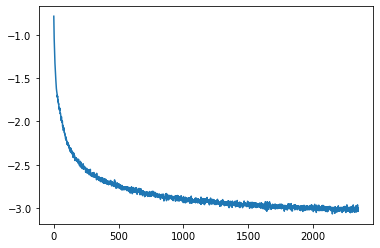

In [8]:
train_data = MNIST('data', train=True, download=True, transform=ToTensor())
train_data_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)

train_ae(train_data_loader, encoder, decoder, EPOCHS, LEARNING_RATE, device)

test_imgs = list()
for batch, target in train_data_loader:
    test_imgs.extend(zip(batch, target))
    if len(test_imgs) > 5000:
        break
imgs_list, targets = zip(*test_imgs)
imgs = torch.stack(imgs_list).to(device)

Проецирование скрытого пространства на плоскость..


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


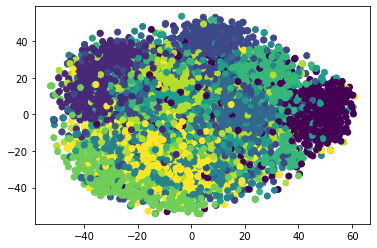

Готово!


In [9]:
print('Проецирование скрытого пространства на плоскость..')
tsne = TSNE()
latent_imgs_emb = [encoder.sample_latent(img.unsqueeze(0))[0].cpu().detach()[0].numpy() for img in imgs]
latent_imgs_emb = tsne.fit_transform(np.array(latent_imgs_emb))
x, y = zip(*latent_imgs_emb)
plt.scatter(x, y, c=targets)
plt.show()
print('Готово!')

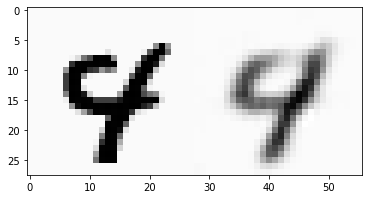

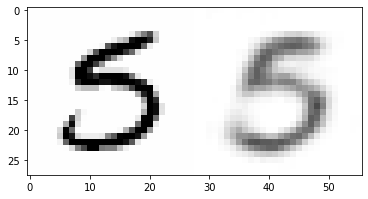

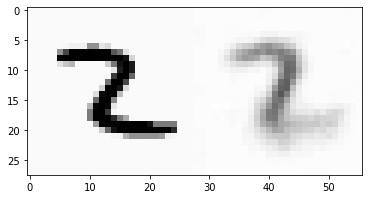

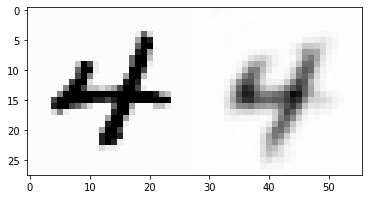

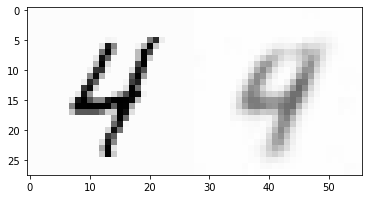

In [14]:
latent_imgs = encoder(imgs)[0]
restored_imgs = decoder(latent_imgs)
size = restored_imgs.shape[0]
restored_imgs = torch.reshape(restored_imgs, (size, 1, 28, 28))
for i in range(5):
    orig_restored = torch.hstack((imgs[i][0], restored_imgs[i][0].detach()))
    plt.imshow(orig_restored.cpu().numpy(), cmap='Greys')
    plt.show()

Рассчет анимации..
Готово!


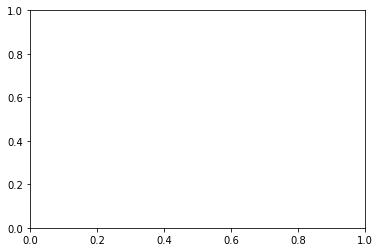

In [13]:
print('Рассчет анимации..')
figure = plt.figure()
ax = figure.add_subplot(1, 1, 1)
animation_data = list()
for i in range(4 * 20):
    frames_per_conn = ANIMATION_N_FRAMES // (ANIMATION_IMAGES - 1)
    vec_index = i // frames_per_conn
    t = i % frames_per_conn / frames_per_conn
    interp_vec = lerp(latent_imgs[vec_index], latent_imgs[vec_index + 1], t)
    restored_img = decoder(interp_vec.unsqueeze(0)).reshape(-1, 1, 28, 28)
    animation_data.append(restored_img[0][0].detach().cpu().numpy())
print('Готово!')

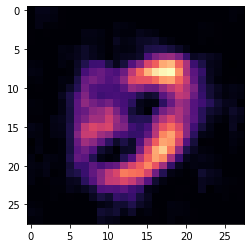

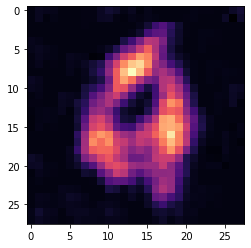

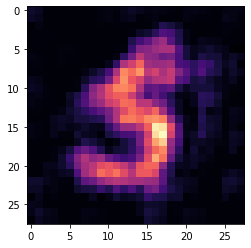

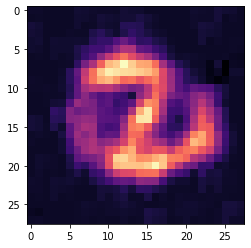

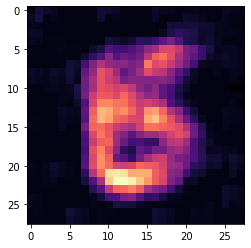

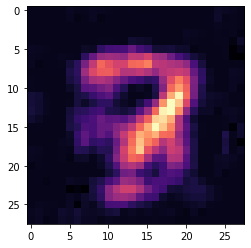

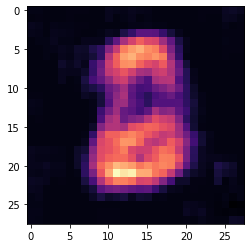

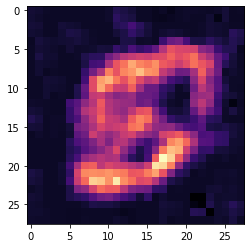

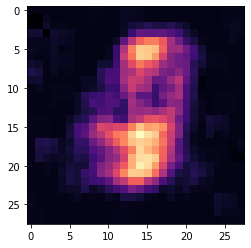

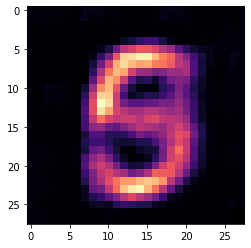

In [12]:
animation = FuncAnimation(figure, get_frame, frames=ANIMATION_N_FRAMES, interval=ANIMATION_INTERVAL, fargs=(animation_data,))

for _ in range(10):
    gen_latent = torch.randn(1, LATENT_SIZE, device=device)
    gen_digit = decoder(gen_latent).cpu().reshape(-1, 1, 28, 28)
    plt.imshow(gen_digit.detach()[0][0].numpy(), cmap='magma')
    plt.show()